# Instituto Tecnológico de Estudios Superiores de Occidente

![nombre de la imagen](https://tys.academia.iteso.mx/wp-content/uploads/sites/39/2015/07/iteso-horizontal.png)

# MicroEstructura y Sistemas de Trading
## Proyecto Final
### Eduardo Omar Ortega
### Ángel René Ruiz 

-------------------------------------------------------------------------------------------------------------------------

#### Indicaciones varias
Para hacer uso del código que se presentará a continuación, deben de estar instaladas las siguientes paqueterías en la computadora respectiva:
- numpy
- pyswarm
- pandas
- oandapyv20
- pandas
- twilio

## Introducción
El presente trabajo tiene como fin realizar una optimización en una herramienta del análisis técnico llamado RSI (Relative Strength Index), aplicado al tipo de cambio USD/MXN en un plazo de 3 años.

## 0.1 Diagrama de flujo

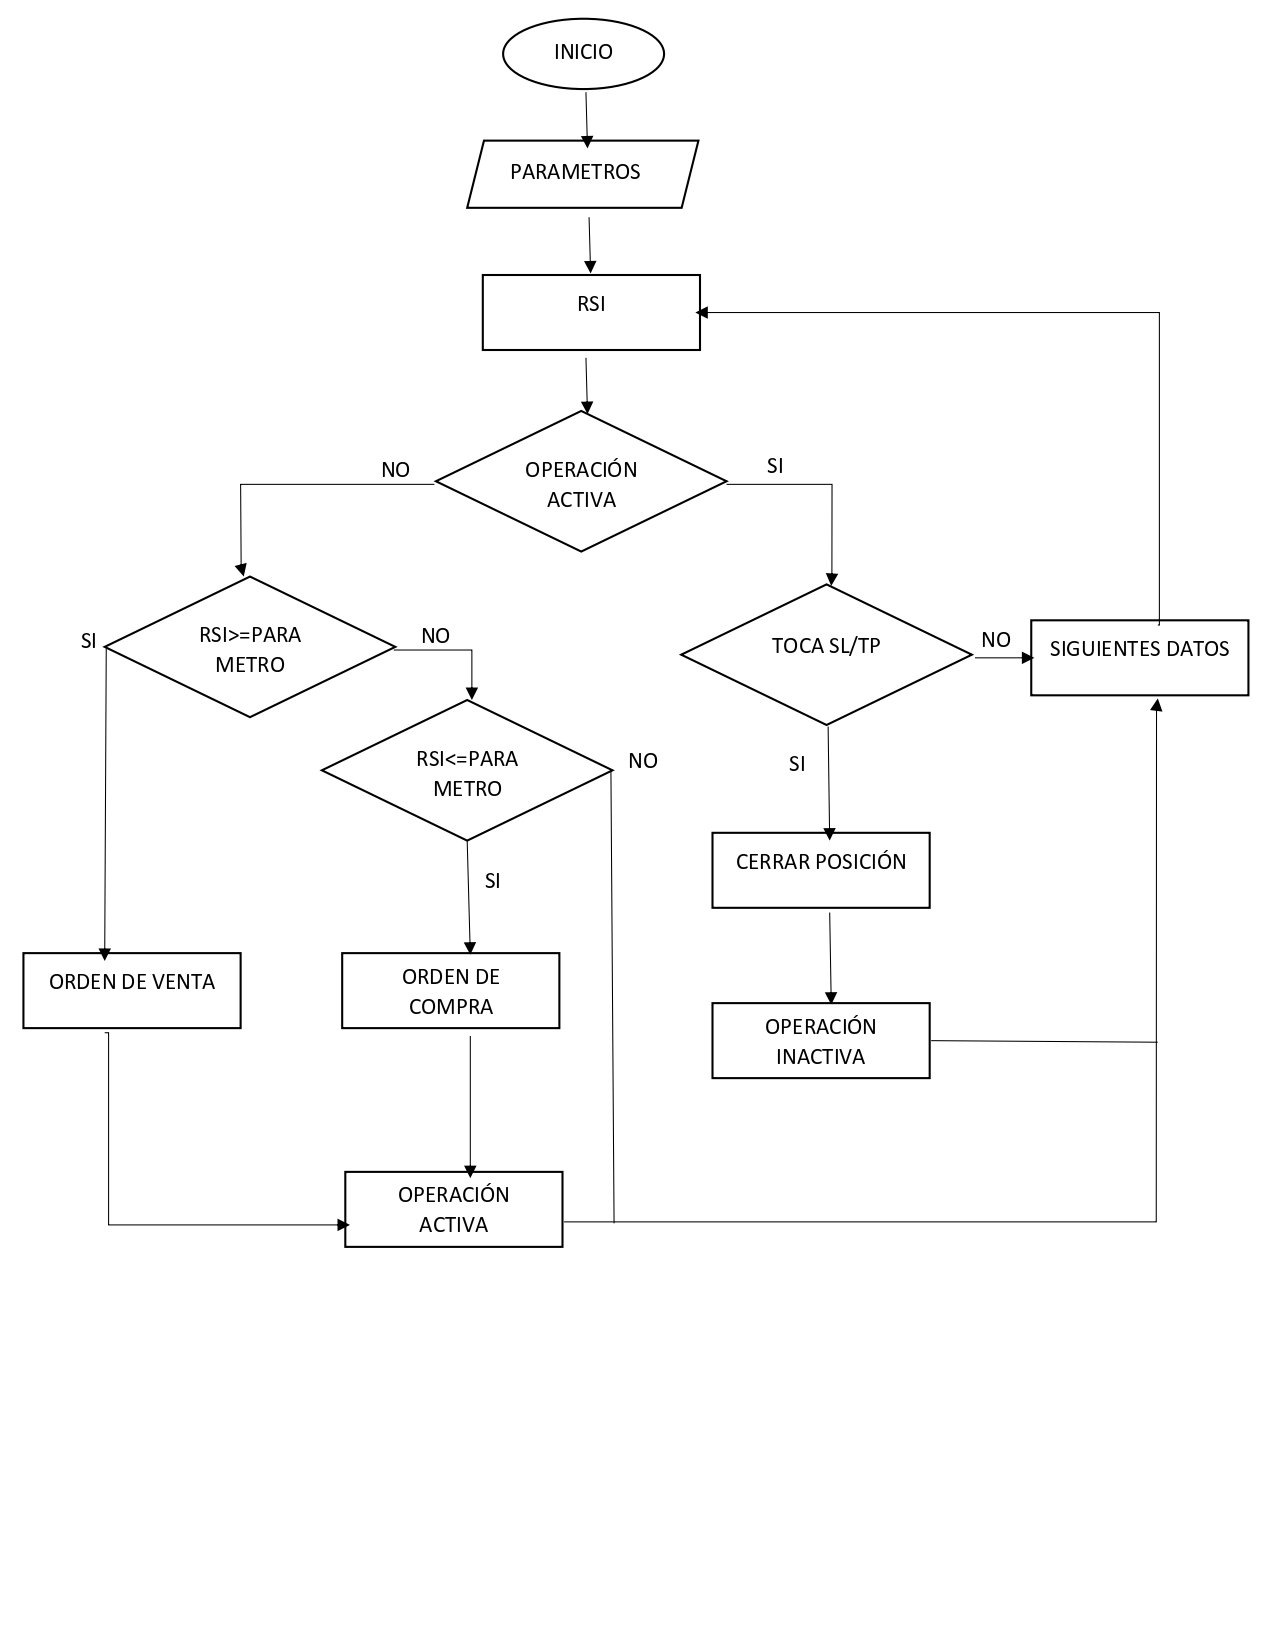

## 0.2
Nuestro proceso para la toma de decisiones en esta estrategia se compone de la siguiente manera: 

Primeramente, insertamos los paramétros a los cuales nos vamos apegar para la toma de decisiones, calculamos el valor del RSI mediante una fórmula matemática que se explicara en el siguiente bloque. Tomando el caso que no existe ninguna operación activa, se compara el valor del RSI contra los parametros previamente introducidos, de complir con alguno se ejectua una orden, ya sea de compra o de venta, dependiendo el valor. Posteriormente, se activa una operación, y continua a los siguientes datos. En el caso de no cumplir con ningun parámetro, se continua a los siguientes datos. Cuando sí existe una operación activa, dependiendo si toca algun parametro de Stop Loss o Take Profit toma cierto camino, de ser el caso que sí toca, automáticamente se cierra la posición y se pone como inactiva la operación. Al final de ambos casos se pasa a los siguientes datos.



	


## 0.3 Principio Matemático
El RSI (Relative Strength Index) es un indicador utilizado en el análisis técnico para predecir tendencias en los precios y saber si un activo se encuentra sobrevaluado o subvaluado. El RSI trata de identificar un cambio de tendencia en los precios de los activos.


$$RSI = {100}-{100\over 1+{AUPC\over ADPC}}.$$

- AUPC: Average of Upward Price Change
- ADPC: Average of Downward Price Change

# Optimización
## 1.1 Identificación de parámetros

Los parametros que vamos se optimizarán son los siguientes:
- RSI UP: Criterio de RSI superior para considerar como sobrevaluado. (Desde 70 hasta 95, con paso .5)
- RSI DOWN: Criterio de RSI superior para considerar como subvaluado. (Desde 5 hasta 30, con paso .5)
- Stop Loss: Criterio para cerrar posición si se está perdiendo. (Desde -100 hasta -10, con paso .5)
- Take Profit: Criterio para cerrar posición si se está ganando. (Desde -10 hasta 100, con paso .5)
- Ventana: Cantidad de periodos a recorrer para la fórmula del RSI. (Desde 14 hasta 56, con paso 1)

## 1.2 Espacio de búsqueda
Dado que tenemos 5 parámetros para optimizar y cada uno cuenta con diferentes posibles valores, los escenarios posibles son demasiados. El tamaño total del espacio es de:
- 3,578,877,162 posibles escenarios

## 1.3 Método de optimización
El método de optimización utilizado para este trabajo es la optimización por enjambres de partículas (conocida como PSO, por sus siglas en inglés, Particle Swarm Optimization).

El PSO es una técnica de optimización/búsqueda y se inspira en el comportamiento de los enjambres de animales en la naturaleza. En concreto, podemos pensar en un enjambre de abejas, ya que éstas a la hora de buscar polen buscan la región del espacio en la que existe más densidad de flores, porque la probabilidad de que haya polen es mayor. La misma idea fue trasladada al campo de la computación en forma de algoritmo y se emplea en la actualidad en la optimización de distintos tipos de sistemas.



# Inicio de Código

A continuación se explicará cómo se fue desarrollando el código para lograr los objetivos planteados en un inicio.


###### Importación de librerías a utilizar

In [31]:
import numpy as np
from pyswarm import pso
import pandas as pd
from oandapyV20 import API
import oandapyV20.endpoints.instruments as instruments
from dateutil.relativedelta import relativedelta
import numpy as np
import math
import time
from datetime import datetime
from twilio.rest import Client
import matplotlib.pyplot as plt

##### Ponemos folio de cuenta de twilio, así como el token para mandar resultados via SMS en tiempo real

In [32]:
account_sid = "AC7ca38f83e6fec4679c7ed1ff8fa2e036"
# Your Auth Token from twilio.com/console
auth_token  = "dc8dc79a5e89417c4e3319ff0551c265"

client =Client(account_sid, auth_token)

##### Definimos las funciones necesarias para los procesos internos del código

In [33]:
# =============================================================================
# Definimos funciones a utilizar
# =============================================================================
def sms(texto):
    message = client.messages.create(
        to="+523310116171", 
        from_="+12024101431",
        body=texto)
def date_range(start_date, end_date, increment, period):
    #Funcion que crea vector de fechas con incremento especifico
    result = []
    nxt = start_date
    delta = relativedelta(**{period:increment})
    while nxt <= end_date:
        result.append(nxt)
        nxt += delta
    return result

def ag_car(cadena):
    #Funcion que agrega caracteres a cadena, fin especifico para funcion de oanda
    nueva=cadena[0:10]+"T"+cadena[11:-1]+"Z"
    return nueva
def rsi_fun(prices,ind,n):
    #Funcion que obtiene el RSI de ciertos precios con cierto periodo
    
    gains=[]
    losses=[]
    ind=ind-(n)
    for i in range(n) :
        dife=float(prices[ind+1])-float(prices[ind])
        if dife>=0:
            gains.append(dife)
        else:
            losses.append(dife*-1)
        ind=ind+1
    gains=np.array(gains)
    losses=np.array(losses)
    rsi=100-(100/(1+((gains.sum()/14)/(losses.sum()/14))))
    return rsi

##### Inicialización de parámetros para usar función de Oanda 

In [34]:
start_date = datetime(2016, 4, 1)
end_date = datetime(2019, 4, 1)
fechas = date_range(start_date, end_date, 5, 'minutes')#Creamos vector de fechas con intervalo de 5 minutos

A1_OA_Da = 17                     # Day Align
A1_OA_Ta = "America/Mexico_City"  # Time Align

A1_OA_Ai = "101-004-2221697-001"  # Id de cuenta
A1_OA_At = "practice"             # Tipo de cuenta

A1_OA_In = "USD_MXN"              # Instrumento
A1_OA_Gn = "M5"                   # Granularidad de velas

A1_OA_Ak = "a1a2738e43e01183e07cbb8dec8e2ca4-771e2b55a25bd1f6cb73b42ca4b1f432"


F1=ag_car(str(fechas[0])) #Fecha 1 inicial
F2=ag_car(str(fechas[5000])) #Fecha 2 inicial

# =============================================================================
# Inicializar API de Oanda
# =============================================================================
api = API(access_token=A1_OA_Ak)
#

lista = [] #Inicializamos lista 
n=5000

##### Ciclo para descargar precios de oanda

In [35]:
while pd.to_datetime(F2)<fechas[-1]:
    params = {"granularity": A1_OA_Gn, "price": "M", "dailyAlignment": A1_OA_Da,
              "alignmentTimezone": A1_OA_Ta, "from": F1, "to": F2}
    A1_Req1 = instruments.InstrumentsCandles(instrument=A1_OA_In, params=params)
    A1_Hist = api.request(A1_Req1)
    
    for i in range(len(A1_Hist['candles'])-1):

            lista.append({'TimeStamp': A1_Hist['candles'][i]['time'],
                          'Open': A1_Hist['candles'][i]['mid']['o'],
                          'High': A1_Hist['candles'][i]['mid']['h'],
                          'Low': A1_Hist['candles'][i]['mid']['l'],
                          'Close': A1_Hist['candles'][i]['mid']['c']})
            
    F1=ag_car(str(fechas[n+1]))
    n=n+5000
    try:F2=ag_car(str(fechas[n]))
    except IndexError:
        break

##### Definimos DataFrames de Precios, Operaciones, y Cuenta, donde estaremos llenando la información histórica.

In [14]:
# =============================================================================
# Data Frame 1: Precios
# =============================================================================
df1_precios = pd.DataFrame(lista)
df1_precios = df1_precios[['TimeStamp', 'Open', 'High', 'Low', 'Close']]
df1_precios['TimeStamp'] = pd.to_datetime(df1_precios['TimeStamp'])
#%%
# =============================================================================
# Data Frame 2: Operaciones
# =============================================================================
n=len(df1_precios)
data=np.empty((n,8))
df2_operaciones=pd.DataFrame(data,columns=['Fecha','Folio','Operacion',
                             'Unidades','Margen','Comentario','Precio_Apertura',
                             'Precio_Cierre']).replace(0,"-")
df2_operaciones['Fecha']=df1_precios.iloc[:,0]
# =============================================================================
# Data Frame 3: Cuenta
# =============================================================================
data=np.empty((n,6))
df3_cuenta=pd.DataFrame(data,columns=['Fecha','Capital','Flotante',
                             'Balance','Rendimiento','Comentario']).replace(0,"-")
df3_cuenta['Fecha']=df1_precios.iloc[:,0]


##### Definimos nuestra función prinicipal; ésta recibirá los parámetros explicados en un inicio del notebook, regresándonos el rendimiento final 

In [28]:
def main_function(x):
    up_rsi,down_rsi,stop_loss,take_profit,ventana,fin=x[0],x[1],x[2],x[3],int(x[4]),500
    capital_i=100000 #Capital Inicial USD
    flotante=0 
    df3_cuenta["Capital"][0:ventana]=capital_i
    flotante=0 
    df3_cuenta["Flotante"][0:ventana]=flotante
    df3_cuenta["Balance"][0:ventana]=capital_i+flotante
    p_o=.10 #Porcentaje de capital por operacion
    cap=capital_i
    oper_act=False
    folio_v=1
    folio_c=1
    venta=False
    for i in range(ventana,fin):
        rsi_=rsi_fun(df1_precios.iloc[:,2],i,ventana)
        open_price=float(df1_precios.iloc[i,1])
        #hi_price=float(df1_precios.iloc[i,2])
        #low_price=float(df1_precios.iloc[i,3])
        close_price=float(df1_precios.iloc[i,4])
       
        if rsi_>=up_rsi and oper_act==False :
            #Cambios en Data Frame 2: Operaciones
            df2_operaciones.iloc[i,1]="V_"+str(folio_v)
            df2_operaciones.iloc[i,2]=-1
            monto=p_o*cap
            unidades=math.floor(monto)
            df2_operaciones.iloc[i,3]=unidades
            df2_operaciones.iloc[i,5]="RSI a: "+str(rsi_)
            df2_operaciones.iloc[i,6]=open_price
            #Cambios en Data Frame 3: Cuenta
            cap=cap-monto
            df3_cuenta.iloc[i,5]="Se abrió operación: venta"
            texto=str(df3_cuenta.iloc[i,0])+" Se abrió operación: venta"
            plt.axvline(x=df3_cuenta.iloc[i,0],color="r")
            #sms(texto)
            precio_operacion=open_price
            #Cambios generales por operacion
            ult_folio="V_"+str(folio_v)
            folio_v+=1
            oper_act=True
            venta=True
    
        if rsi_<=down_rsi and oper_act==False :
            #Cambios en Data Frame 2: Operaciones
            df2_operaciones.iloc[i,1]="C_"+str(folio_c)
            df2_operaciones.iloc[i,2]=1
            monto=p_o*cap
            unidades=math.floor(monto)
            df2_operaciones.iloc[i,3]=unidades
            df2_operaciones.iloc[i,5]="RSI a: "+str(rsi_)
            df2_operaciones.iloc[i,6]=open_price
            #Cambios en Data Frame 3: Cuenta
            cap=cap-monto
            df3_cuenta.iloc[i,5]="Se abrió operación: compra"
            plt.axvline(x=df3_cuenta.iloc[i,0],color="b")
            texto=str(df3_cuenta.iloc[i,0])+" Se abrió operación: compra"
            #sms(texto)
            precio_operacion=open_price
            #Cambios generales por operacion
            ult_folio="C_"+str(folio_c)
            folio_c+=1
            oper_act=True
        if oper_act==True: #Si existe una operación activa
            if venta:#Si la operación activa es una venta
                flotante=((precio_operacion-close_price)*unidades)/close_price+unidades
            else:
                flotante=((close_price-precio_operacion)*unidades)/close_price+unidades
            pr_lo= flotante-unidades
            if pr_lo>=take_profit or pr_lo<=stop_loss: #Si se cumple alguno de los parametros
                df3_cuenta.iloc[i,1]=cap+flotante
                cap=cap+flotante
                df3_cuenta.iloc[i,2]=0
                df3_cuenta.iloc[i,3]=df3_cuenta.iloc[i,1]
                df3_cuenta.iloc[i,4]=df3_cuenta.iloc[i,3]/capital_i-1
                df3_cuenta.iloc[i,5]="Se cerró operación: Con pérdida/ganancia: " + str(pr_lo)
                
                df2_operaciones.iloc[i,1]=ult_folio
                if pr_lo<=stop_loss: #Si se cumple el stop loss
                    df2_operaciones.iloc[i,5]="Se ejecutó Stop Loss: "+str(pr_lo)
                else:
                    if pr_lo>=take_profit: #Si se cumple el take profit
                        df2_operaciones.iloc[i,5]="Se ejecutó Take Profit: "+str(pr_lo)
                df2_operaciones.iloc[i,7]=close_price
                oper_act=False #Ponemos como inactiva las operación abierta
            else: #Si no se cumple ningun parametro (stop loss,take profit)
                df3_cuenta.iloc[i,1]=cap
                df3_cuenta.iloc[i,2]=flotante
                df3_cuenta.iloc[i,3]=df3_cuenta.iloc[i,1]+df3_cuenta.iloc[i,2]
                df3_cuenta.iloc[i,4]=df3_cuenta.iloc[i,3]/capital_i-1
        else: #si no existe alguna operación activa
            df3_cuenta.iloc[i,1]=cap
            df3_cuenta.iloc[i,2]=0
            df3_cuenta.iloc[i,3]=df3_cuenta.iloc[i,1]+df3_cuenta.iloc[i,2]
            df3_cuenta.iloc[i,4]=df3_cuenta.iloc[i,3]/capital_i-1
        
    rendimiento_final=df3_cuenta.iloc[i-1,4]
    y=df1_precios["Close"][0:i-1].astype(float)
    x=df1_precios.iloc[0:i-1,0]
    plt.plot(x,y)
  
    
    return -rendimiento_final


# NO CORRER (TARDA MUCHO):
##### Proceso de optimización mediante modulo PSO de librería pyswarm.

In [4]:
permiso=raw_input()

if permiso==True:
    low_var=[70,5,-100,10,14] #Definimos los valores mínimos de nuestros parámetros
    up_var=[95,30,-10,100,56] #Definimos los valores máximos de nuestros parámetros

    xopt, fopt = pso(main_function, low_var, up_var, ieqcons=[], f_ieqcons=None, args=(), kwargs={},
        swarmsize=1000, omega=0.5, phip=0.5, phig=0.5, maxiter=100, minstep=.5,
        minfunc=1e-8, debug=True)
else:
    print("Acceso Denegado")

sd
Acceso Denegado


## 1.4 Visualización de resultados
### Resultados de optimización
- RSI UP: 
- RSI DOWN: 
- Stop Loss: 
- Take Profit:
- Ventana:

### Gráfico de Espacio de Búsqueda


### Gráfico de convergencia a solución


## 2.1 Gráfico Precio vs Operaciones

C:\Users\eduor\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\eduor\Anaconda2\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\eduor\Anaconda2\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


-0.000127669518989


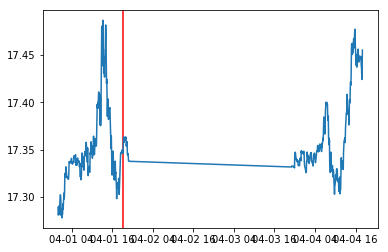

In [29]:
x=[89,8,-10,80,14]
print(main_function(x))